In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

import re
from nltk.tokenize import WhitespaceTokenizer

import warnings
warnings.filterwarnings('ignore')

In [101]:
filename =  '../data/pubmed_vectorized_jargon.csv'

In [102]:
df = pd.read_csv(filename).set_index('pmid').sort_index()

In [103]:
df.head()

,citations,fulltext,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
pmid,,,,,,,,,,,,,,,,,,,,,
22075226,12,membrane protein structural bioinformatics des...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
22366294,51,evaluating state art coreference resolution el...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
22528508,20,paradigm shift toxicity testing modeling limit...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
22611119,26,machine learning approaches discovery genegene...,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
22627698,35,extracting biological information computationa...,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,11


### Investigation I: Modeling Citations as Target

#### Transform the Target into a Binary Variable

In [104]:
#set a threshold for 'highly-cited' established during EDA 
thresh = 10

In [105]:
#check how many posts meet that criterion
(df['citations'] > thresh).sum()

678

In [106]:
citations = [1 if citation > thresh else 0 for citation in df['citations']]

In [107]:
df['citations'] = citations

In [108]:
df['citations'].value_counts(normalize=True)

0    0.758633
1    0.241367
Name: citations, dtype: float64

In [109]:
df.columns

Index(['citations', 'fulltext', 'A/B testing', 'accuracy', 'action',
       'activation function', 'active learning', 'AdaGrad', 'agent',
       'agglomerative clustering',
       ...
       'user matrix', 'validation', 'validation set',
       'vanishing gradient problem', 'Wasserstein loss', 'weight',
       'Weighted Alternating Least Squares (WALS)', 'wide model', 'width',
       'total_jargon_count'],
      dtype='object', length=415)

#### Classification Modeling

In [11]:
#confirm no nulls 
df.isnull().sum().sum()

0

In [14]:
X = df.drop(columns=['citations','fulltext','log_citations'])
y = df['citations']

In [15]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                  stratify=y,
                                                 random_state=42)

#### Run Through Classifiers

In [16]:
model_list = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    BaggingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SVC(),
    BernoulliNB()
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train, y_train)
    results_dict['test_score'] = model.score(X_test, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train, y_train, cv = 5).mean()
    results_dict['precision_score'] = precision_score(y_test, model.predict(X_test))
    results_dict['train_f1_score'] = f1_score(y_train, model.predict(X_train))  
    results_dict['test_f1_score'] = f1_score(y_test, model.predict(X_test))  
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [17]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,precision_score,train_f1_score,test_f1_score
0,LogisticRegression(),0.713191,0.693654,0.684728,0.409091,0.132450,0.113924
1,DecisionTreeClassifier(),0.974822,0.601751,0.602639,0.328358,0.956190,0.325926
2,BaggingClassifier(),0.944718,0.678337,0.664479,0.400000,0.900493,0.230366
3,RandomForestClassifier(),0.974822,0.684902,0.676519,0.366667,0.956604,0.132530
4,AdaBoostClassifier(),0.727422,0.678337,0.673235,0.342857,0.229102,0.140351
5,SVC(),0.705528,0.702407,0.703887,0.000000,0.014652,0.000000
6,BernoulliNB(),0.717022,0.702407,0.689108,0.500000,0.153846,0.105263


None of these models are better than baseline at predicting whether a post will be highly-cited or not.

### Investigation II: Effect of Proportion of Jargon on Number of Citations

In [110]:
df.head()

,citations,fulltext,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
pmid,,,,,,,,,,,,,,,,,,,,,
22075226,1,membrane protein structural bioinformatics des...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
22366294,1,evaluating state art coreference resolution el...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
22528508,1,paradigm shift toxicity testing modeling limit...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
22611119,1,machine learning approaches discovery genegene...,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
22627698,1,extracting biological information computationa...,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,11


In [111]:
#read in stemmed preprocessed abstracts to get total word count
pubmed = pd.read_csv('../data/pubmed_nltk_stemmed_preproc.csv').set_index('pmid').sort_index()

In [112]:
pubmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2809 entries, 22075226 to 33948244
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2809 non-null   object
 1   citations  2809 non-null   int64 
 2   len_text   2809 non-null   int64 
 3   len_title  2809 non-null   int64 
 4   days_live  2809 non-null   int64 
 5   fulltext   2809 non-null   object
dtypes: int64(4), object(2)
memory usage: 153.6+ KB


In [113]:
#remove punctuation characters 
pubmed['fulltext'] = pubmed['fulltext'].replace("[''·,\.!?'-]",'',regex=True)
#remove brackets surrounding the text
pubmed['fulltext']  = pubmed['fulltext'].map(lambda x: x.replace("[",""))
pubmed['fulltext'] = pubmed['fulltext'].map(lambda x: x.replace("]",""))

In [114]:
#tokenize text into lists to get word count
w_tokenizer = WhitespaceTokenizer()
pubmed['words']  = pubmed['fulltext'].apply(lambda x: w_tokenizer.tokenize(x))
pubmed['word_count'] = pubmed['words'].apply(lambda x: len(x))

In [115]:
pubmed.head()

,date,citations,len_text,len_title,days_live,fulltext,words,word_count
pmid,,,,,,,,
22075226,2012-09-01,12,1024,42,3171,membran protein structur bioinformat despit in...,"[membran, protein, structur, bioinformat, desp...",93
22366294,2012-10-01,51,1643,88,3141,evalu state art corefer resolut electron medic...,"[evalu, state, art, corefer, resolut, electron...",153
22528508,2012-09-01,20,1717,47,3171,paradigm shift toxic test model limit tradit t...,"[paradigm, shift, toxic, test, model, limit, t...",163
22611119,2013-03-01,26,819,87,2990,machin learn approach discoveri genegen intera...,"[machin, learn, approach, discoveri, genegen, ...",76
22627698,2012-07-01,35,1780,165,3233,extract biolog inform comput analysi fouriertr...,"[extract, biolog, inform, comput, analysi, fou...",165


In [116]:
# calculate word count, jargon count, and jargon proportion 
jargon_count = pd.Series(df['total_jargon_count'])
word_count = pd.Series(pubmed['word_count'])

jargon_prop = jargon_count/word_count

In [117]:
#Create new dataframe with jargon prop and citations
prop = pd.DataFrame()
prop['jargon_prop'] = pd.Series(jargon_prop)
prop['citations'] = df['citations']
prop.head(20)

,jargon_prop,citations
pmid,,
22075226,0.021505,1
22366294,0.026144,1
22528508,0.067485,1
22611119,0.078947,1
22627698,0.066667,1
22695048,0.024691,1
22752090,0.063492,1
22776068,0.075000,0
22784485,0.033708,1


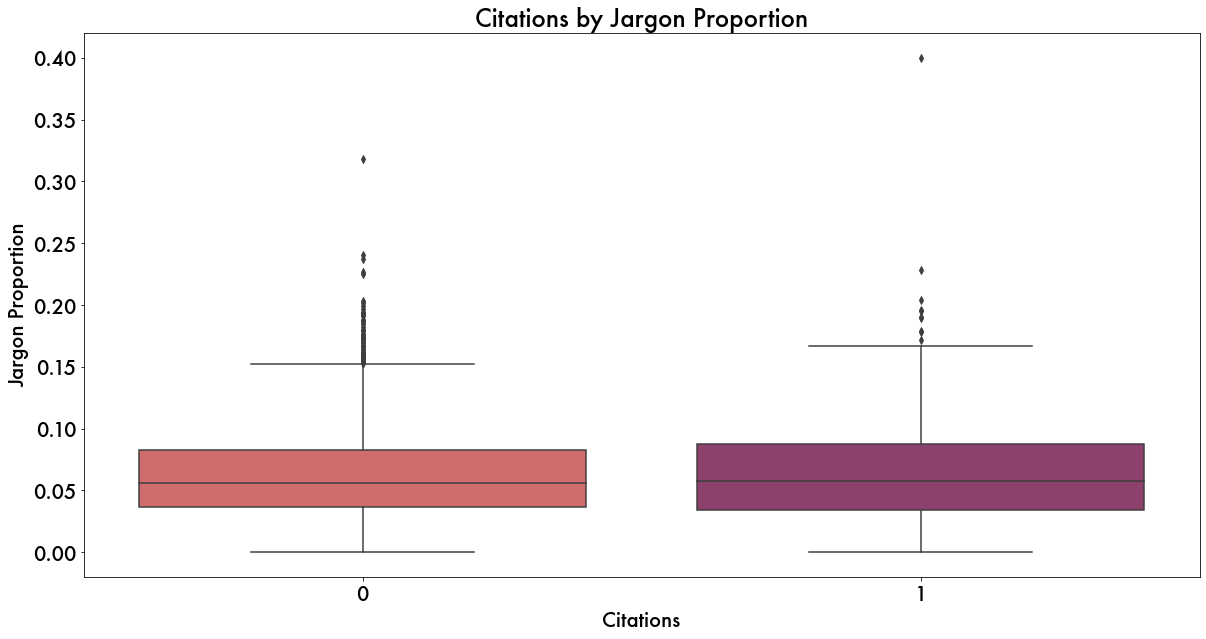

In [118]:
plt.figure(figsize = (20, 10));
sns.boxplot(data=prop, x='citations', y = 'jargon_prop', palette='flare');
figurefont = {'fontname' : 'Futura'};
plt.title('Citations by Jargon Proportion', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Citations',**figurefont, fontsize = 20);
plt.ylabel('Jargon Proportion',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_jargon_class_boxplot.jpg',  bbox_inches = "tight")